### I. Librairies

In [1]:
import tensorflow as tf
print('tensorflow version:',tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

tensorflow version: 2.1.0
Num GPUs Available: 1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

In [21]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [4]:
%matplotlib inline
random_state = 42
np.random.seed(random_state)

### II. Data Loading

In [5]:
def loadEMNIST(file_path):
    data = pd.read_csv(file_path,header=None)
    X = data.iloc[:,1:].values
    X = X.reshape(X.shape[0], 28, 28, 1)
    X = np.flip(np.rot90(X, k = 3, axes = (1,2)), axis = 2)
    y = data.iloc[:,0].values
    return X, y

##### II.a Train

In [6]:
X_train, y_train = loadEMNIST("Data/emnist-letters-train.csv")
y_train = y_train + 9 # digit_labels: [0<->9], letters_labels: [10<->35]
temp_X, temp_y = loadEMNIST("Data/emnist-digits-train.csv")
X_train = np.concatenate((X_train, temp_X))
y_train = np.concatenate((y_train, temp_y))

##### II.b Validation

In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size = 0.85,
                                                                random_state = random_state,
                                                                stratify = y_train, shuffle = True)

##### II.c Test

In [8]:
X_test, y_test = loadEMNIST("Data/emnist-letters-test.csv")
y_test = y_test + 9 # digit_labels: [0<->9], letters_labels: [10<->35]
temp_X, temp_y = loadEMNIST("Data/emnist-digits-test.csv")
X_test = np.concatenate((X_test, temp_X))
y_test = np.concatenate((y_test, temp_y))
print(X_test.shape, y_test.shape)

(54800, 28, 28, 1) (54800,)


In [9]:
print(f"Train/Validation/Test size: {X_train.shape[0]}/{X_validation.shape[0]}/{X_test.shape[0]}")

Train/Validation/Test size: 279480/49320/54800


##### II.d Display

In [10]:
def labelToChar(label):
    if label < 10:
        return chr(label + 48)
    return chr(label + 55)

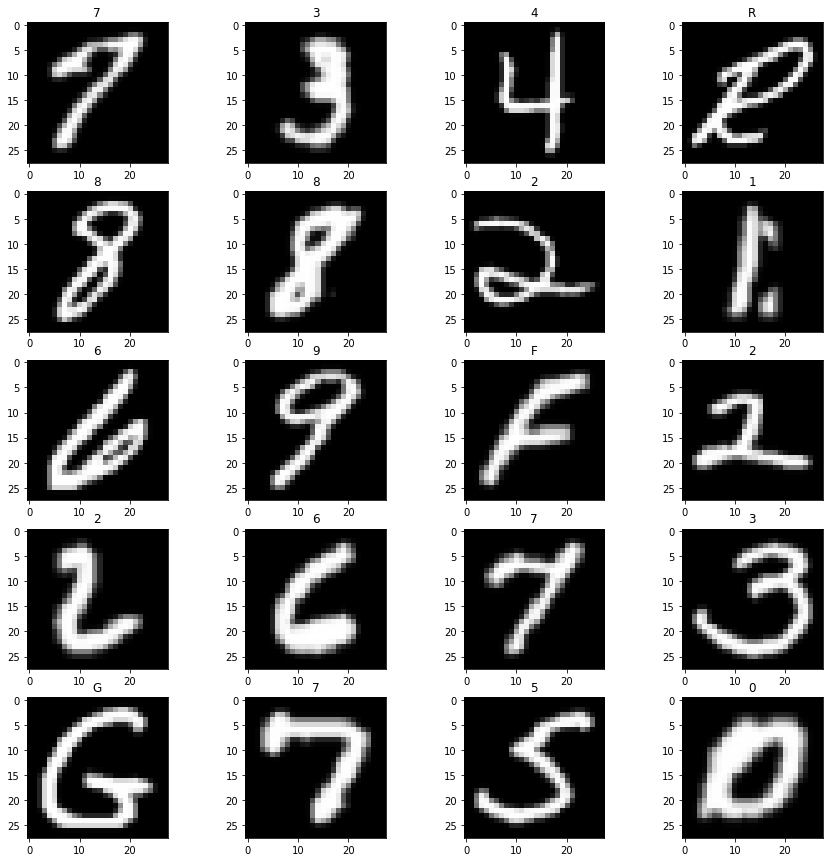

In [12]:
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    i_img = np.random.randint(0, X_train.shape[0])
    plt.imshow(X_train[i_img].reshape(28,28), cmap='gray', vmin=0, vmax=255)
    plt.title(labelToChar(y_train[i_img]))
plt.show()

##### II.d Normalisation and reshaping

In [13]:
X_train = X_train / 255
X_validation = X_validation / 255
X_test = X_test / 255


y_train = to_categorical(y_train)
y_validation = to_categorical(y_validation)
y_test = to_categorical(y_test)

##### II.e Data Augmentation

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

### III.Training

In [22]:
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.00001)

In [28]:
model=Sequential()

model.add(Conv2D(64,(5,5),input_shape=(28,28,1),activation='relu', data_format="channels_last", padding="same"))
model.add(Conv2D(64,(5,5),activation='relu', data_format="channels_last", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(3,3),activation='relu', data_format="channels_last", padding="same"))
model.add(Conv2D(128,(3,3),activation='relu', data_format="channels_last", padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dense(y_train.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)        

In [29]:
model.fit(datagen.flow(X_train,y_train, batch_size=256), epochs = 20,
          validation_data = (X_validation, y_validation), callbacks = [lrr])

  ...
    to  
  ['...']
Train for 1092 steps, validate on 49320 samples
Epoch 1/20
1092/1092 [==============================] - 90s 82ms/step - loss: 0.4490 - accuracy: 0.8703 - val_loss: 0.2145 - val_accuracy: 0.9329
Epoch 2/20
1092/1092 [==============================] - 88s 81ms/step - loss: 0.2513 - accuracy: 0.9225 - val_loss: 0.2036 - val_accuracy: 0.9381
Epoch 3/20
1092/1092 [==============================] - 87s 80ms/step - loss: 0.2255 - accuracy: 0.9298 - val_loss: 0.1908 - val_accuracy: 0.9406
Epoch 4/20
1092/1092 [==============================] - 88s 80ms/step - loss: 0.2136 - accuracy: 0.9333 - val_loss: 0.1811 - val_accuracy: 0.9427
Epoch 5/20
1092/1092 [==============================] - 88s 81ms/step - loss: 0.2038 - accuracy: 0.9361 - val_loss: 0.1832 - val_accuracy: 0.9426
Epoch 6/20
1092/1092 [==============================] - 88s 81ms/step - loss: 0.1983 - accuracy: 0.9372 - val_loss: 0.1687 - val_accuracy: 0.9453
Epoch 7/20
1092/1092 [=============================

KeyboardInterrupt: 

### IV. Test

In [14]:
loss, accuracy = model.evaluate(X_train, y_train, verbose = 0)
print(f"Train loss: {loss:.3f} Train accuracy: {100*accuracy:.2f}")
loss, accuracy = model.evaluate(X_validation, y_validation, verbose = 0)
print(f"Validation loss: {loss:.3f} Validation accuracy: {100*accuracy:.2f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose = 0)
print(f"Test loss: {loss:.3f} Test accuracy: {100*accuracy:.2f}")

Train loss: 0.032 Train accuracy: 98.97
Validation loss: 0.052 Validation accuracy: 98.51
Test loss: 0.060 Test accuracy: 98.32


### V. Save model

In [6]:
model_name = "character_model"
folder = 'Models/'

# serialize model to JSON
model_json = model.to_json()
with open(f"{folder}{model_name}.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(f"{folder}{model_name}.h5")
tf.compat.v1.keras.utils.plot_model(model, to_file=f'{folder}/{model_name}.jpg', show_shapes = True)
print("Saved model to disk")

Saved model to disk


### VI. Convert Model to TfLite

In [16]:
model_name = "character_model"
folder = 'Models/'
converter = tf.lite.TFLiteConverter.from_keras_model(model)# Convert the model
tflite_model = converter.convert()# Create the tflite model file
open(f"{folder}{model_name}.tflite", "wb").write(tflite_model)

4535764

In [17]:
with open('Models/labels.txt', 'w') as f:
    for i in range(y_train.shape[1]):
        f.write(labelToChar(i) + '\n')

### VII Load a saved Model

##### VII.a load keras model

In [4]:
model_name = "character_model"
folder = 'Models/'

# load json and create model
json_file = open(f"{folder}{model_name}.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(f"{folder}{model_name}.h5")
print("Loaded model from disk")
 
# compile the model to be able to use it
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Loaded model from disk


##### VII.b load a tflite model

In [41]:
model_name = "character_model"
folder = 'Models/'
interpreter = tf.lite.Interpreter(model_path=f"{folder}{model_name}.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

[[1.9098491e-03 2.9221010e-05 7.8848071e-02 1.0487825e-02 1.3609478e-02
  7.2245288e-01 5.0908164e-03 2.9968892e-03 9.4838247e-02 6.9613181e-02
  6.8704615e-08 1.9085189e-06 8.7614623e-08 1.6552588e-06 3.3778838e-06
  1.3656469e-07 3.6329668e-05 3.7179319e-07 1.9494722e-07 3.5101029e-06
  4.0903083e-06 9.3594474e-07 1.8835011e-10 6.3280825e-09 4.8269368e-07
  2.8414846e-09 6.1246043e-05 7.1864847e-09 1.5239798e-06 7.2382264e-08
  1.2131127e-07 4.2057908e-09 1.8385256e-07 1.3401466e-07 3.6261840e-06
  3.4079533e-06]]


### VIII Check tflite conversion

In [42]:
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[1.3815466e-03 7.0841075e-04 8.6035796e-02 2.1496231e-02 1.0034459e-01
  5.8482528e-01 9.6075973e-03 2.0692509e-03 7.4604796e-03 1.8199028e-01
  1.5701362e-05 3.8542094e-05 1.2089181e-05 4.4601780e-05 8.4586296e-05
  1.7189992e-05 1.1365495e-03 6.9722823e-06 2.8809864e-04 1.7077924e-04
  2.1979940e-05 4.3023720e-05 4.0053454e-08 7.8575376e-08 3.7666919e-06
  7.6148417e-08 1.1296488e-03 2.6253537e-07 8.1605639e-04 5.4310135e-06
  9.7450602e-06 1.0400754e-07 1.5792402e-06 6.5532362e-07 2.9944391e-05
  2.0307323e-04]]


In [47]:
i_img = np.random.randint(0, X_test.shape[0])
out = model.predict(input_data)
print(out)

[[1.38154626e-03 7.08410866e-04 8.60357806e-02 2.14962307e-02
  1.00344755e-01 5.84825158e-01 9.60759073e-03 2.06925231e-03
  7.46047823e-03 1.81990251e-01 1.57013437e-05 3.85420499e-05
  1.20891891e-05 4.46017693e-05 8.45863542e-05 1.71899901e-05
  1.13654986e-03 6.97228734e-06 2.88098847e-04 1.70779371e-04
  2.19799367e-05 4.30237124e-05 4.00534468e-08 7.85752832e-08
  3.76668731e-06 7.61483250e-08 1.12964807e-03 2.62534797e-07
  8.16055865e-04 5.43101169e-06 9.74504837e-06 1.04007519e-07
  1.57923989e-06 6.55323504e-07 2.99443545e-05 2.03073359e-04]]


In [49]:
print(f"total error: {np.sum(out - output_data)}")

total error: -7.22944548670057e-09
